In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# --- GRR Primitives ---
def grr_perturb(x, domain, epsilon):
    domain = list(domain)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    domain = list(domain)
    n = len(reports)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    q = 1.0 / (exp_eps + k - 1)

    counts = {v: 0 for v in domain}
    for r in reports:
        if r in counts:
            counts[r] += 1
        else:
            raise ValueError(f"Reported value '{r}' not in domain")

    return {v: (counts[v] - n * q) / (n * (p - q)) for v in domain}

In [3]:
def random_split_perturb(df, epsilon):
    """
    Each user perturbs all attributes using equal budget split.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    perturbed = []

    for _, row in df.iterrows():
        noisy_row = [
            grr_perturb(row[col], df[col].unique(), eps_attr)
            for col in df.columns
        ]
        perturbed.append(noisy_row)
    
    return perturbed

def random_split_estimate(reports, df, epsilon):
    """
    Estimate frequencies for each attribute independently.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    reports = np.array(reports)
    estimates = {}

    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        col_reports = reports[:, i]
        estimates[col] = grr_estimate_frequencies(col_reports, domain, eps_attr)

    return estimates


In [4]:
def rs_fd_perturb(df, domains, epsilon):
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    cols = list(domains.keys())
    
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        output = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                output[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                output[col] = np.random.choice(domain)
        privatized.append(output)
    
    return pd.DataFrame(privatized, index=df.index)


def rs_fd_estimate(perturbed_df, domains, epsilon):
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        p = np.exp(epsilon_prime) / (np.exp(epsilon_prime) + kj - 1)
        q = 1.0 / (np.exp(epsilon_prime) + kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()

        est = {}
        for v in domain:
            Ni = counts.get(v, 0)
            est[v] = (Ni * d * kj - n * (d - 1 + q * kj)) / (n * kj * (p - q))
        estimates[col] = est

    return estimates




In [5]:
def rs_rfd_perturb(df, domains, priors, epsilon):
    """
    RS+RFD[GRR] client-side perturbation.

    Args:
        df       : DataFrame of true user data.
        domains  : dict mapping each attribute to its domain.
        priors   : dict of prior distributions (same structure as output of get_true_frequencies).
        epsilon  : privacy budget.

    Returns:
        DataFrame of privatized data.
    """
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    cols = list(df.columns)
    epsilon_prime = epsilon
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)  # index of sampled attribute
        y = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                # Sanitize sampled attribute with GRR
                y[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                # Fake value sampled from prior
                prior_probs = [priors[col].get(v, 0.0) for v in domain]
                prior_probs = np.array(prior_probs)
                prior_probs /= prior_probs.sum()  # ensure normalization
                y[col] = np.random.choice(domain, p=prior_probs)
        privatized.append(y)

    return pd.DataFrame(privatized, index=df.index)
def rs_rfd_estimate(perturbed_df, domains, priors, epsilon):
    """
    RS+RFD[GRR] server-side frequency estimator.

    Args:
        perturbed_df : output of rs_rfd_perturb.
        domains      : dict of attribute → domain list.
        priors       : dict of attribute → {value: prior prob}.
        epsilon      : same ε used in perturbation.

    Returns:
        dict of attribute → {value: estimated frequency}.
    """
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        exp_eps = np.exp(epsilon_prime)
        p = exp_eps / (exp_eps + kj - 1)
        q = (1 - p) / (kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()
        est = {}
        for v in domain:
            C_vi = counts.get(v, 0)
            f_prior = priors[col].get(v, 0.0)
            bias = q + (d - 1) * f_prior
            numerator = d * C_vi - n * bias
            denominator = n * (p - q)
            est[v] = numerator / denominator
        estimates[col] = est

    return estimates


In [6]:
import numpy as np
import pandas as pd

# --- p_y Optimization Function ---
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 1
    return float(np.clip(p_star, 0.0, 1.0))

# --- Phase 1 SPL ---
def corr_rr_phase1_spl(df, epsilon, frac=0.1):
    n = len(df)
    m = int(frac * n)
    df_A = df.iloc[:m]
    eps_split = epsilon / df.shape[1]
    
    reports = []
    for _, row in df_A.iterrows():
        reports.append([
            grr_perturb(row[col], df[col].unique(), eps_split)
            for col in df.columns
        ])
    reports = np.array(reports)
    
    est = {}
    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        est[col] = grr_estimate_frequencies(reports[:, i], domain, eps_split)
    return est, df.iloc[m:]

# --- Phase 2 Corr-RR Perturbation ---
def corr_rr_phase2_perturb(df, epsilon, f_hat_phase1, domain_map, p_y_table):
    d = len(df.columns)
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        perturbed = {}
        for i, col in enumerate(df.columns):
            domain = domain_map[col]
            if i == j:
                perturbed[col] = grr_perturb(row[col], domain, epsilon)
            else:
                pair = (df.columns[j], col)
                py = p_y_table.get(pair, 0.5)
                if np.random.rand() < py:
                    perturbed[col] = row[col]
                else:
                    perturbed[col] = np.random.choice([v for v in domain if v != row[col]])
        privatized.append(perturbed)
    return pd.DataFrame(privatized, index=df.index)

# --- Corr-RR Estimator (using standard GRR) ---
def corr_rr_estimate(perturbed_df, domains, epsilon):
    estimates = {}
    n, d = perturbed_df.shape
    for col, domain in domains.items():
        reports = perturbed_df[col].tolist()
        estimates[col] = grr_estimate_frequencies(reports, domain, epsilon)
    return estimates

# --- Weighted Merge of Phase Estimates ---
def combine_phase_estimates(est_A, est_B, m, n_minus_m):
    combined = {}
    for col in est_A:
        combined[col] = {}
        for v in est_A[col]:
            combined[col][v] = (m * est_A[col][v] + n_minus_m * est_B[col][v]) / (m + n_minus_m)
    return combined


In [7]:
# --- True Frequency Utility ---
def get_true_frequencies(df, columns):
    freq_dict = {}
    for col in columns:
        counts = df[col].value_counts(normalize=True).sort_index()
        freq_dict[col] = counts.to_dict()
    return freq_dict

def correlated_data_generator(domain, n, correlations=None, total_attributes=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    domain = list(domain)
    domain_set = {x: [d for d in domain if d != x] for x in domain}
    df = pd.DataFrame()

    # Add correlated attributes
    if correlations:
        for attr1, attr2, p_same in correlations:
            X1 = np.random.choice(domain, size=n)
            mask = np.random.rand(n) < p_same
            X2 = np.where(mask, X1, [np.random.choice(domain_set[v]) for v in X1])
            df[attr1] = X1
            df[attr2] = X2

    # Decide which attributes to include
    if total_attributes is not None:
        all_attrs = [f'X{i+1}' for i in range(total_attributes)]
    else:
        all_attrs = list(df.columns)

    for attr in all_attrs:
        if attr not in df.columns:
            df[attr] = np.random.choice(domain, size=n)

    return df

# domain = [0, 1, 2, 3]
# correlations = [('X1', 'X2', 0.9), ('X3', 'X4', 0.9)]

# df = correlated_data_generator(domain, n=1000, correlations=correlations, total_attributes=2, seed=42)
# print(df.columns)  # ['X1', 'X2']
# print(df.head())

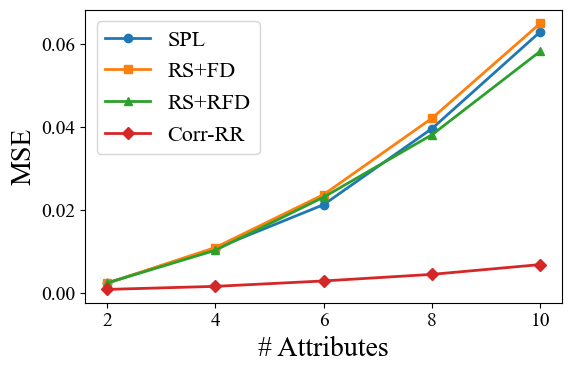

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = [0, 1]                   # binary values
attribute_counts = [2, 4, 6, 8, 10]
epsilon = 0.4                     # fixed privacy budget
n = 10000
m = 0.1                           # fraction for SPL
R = 100                           # number of runs

# Pre-allocate storage: rows=runs, cols=|attribute_counts|
all_spl    = np.zeros((R, len(attribute_counts)))
all_rsfd   = np.zeros((R, len(attribute_counts)))
all_rsrfd  = np.zeros((R, len(attribute_counts)))
all_corrrr = np.zeros((R, len(attribute_counts)))

for run in range(R):
    for idx, d in enumerate(attribute_counts):
        # 1) build columns names and correlations
        columns = [f'X{i+1}' for i in range(d)]
        # fully connect every pair at corr=0.98
        correlations = [
            (columns[i], columns[j], 0.98)
            for i in range(d) for j in range(i+1, d)
        ]

        # 2) generate data & true frequencies
        df = correlated_data_generator(domain, n, correlations=correlations)
        true_freqs = get_true_frequencies(df, columns)
        domains = {col: sorted(df[col].unique()) for col in columns}

        # --- compute MSE for each mechanism at ε=0.1 ---
        # 2a) SPL
        pert_spl = random_split_perturb(df, epsilon)
        est_spl  = random_split_estimate(pert_spl, df, epsilon)
        mse_spl = np.mean([
            np.mean([
                (est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2b) RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, epsilon)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, epsilon)
        mse_rsfd = np.mean([
            np.mean([
                (est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2c) RS + RFD
        priors     = true_freqs  # empirical priors
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, epsilon)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, epsilon)
        mse_rsrfd = np.mean([
            np.mean([
                (est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2d) Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, epsilon, frac=m)
        n_A = int(m * len(df))
        n_B = len(df_B)
        # build p_y for every pair
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b],
                                epsilon, n_A, domain)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, epsilon,
                                             phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, epsilon)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr = np.mean([
            np.mean([
                (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 3) record
        all_spl[run,    idx] = mse_spl
        all_rsfd[run,   idx] = mse_rsfd
        all_rsrfd[run,  idx] = mse_rsrfd
        all_corrrr[run, idx] = mse_corrrr

# --- average over runs ---
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)




# --- plot: #attributes vs MSE curves ---
plt.figure(figsize=(6,4))
plt.plot(attribute_counts, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(attribute_counts, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(attribute_counts, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(attribute_counts, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')

plt.xlabel('# Attributes', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(attribute_counts, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_100k_10_98_eps_0_4.svg", format="svg")

plt.show()


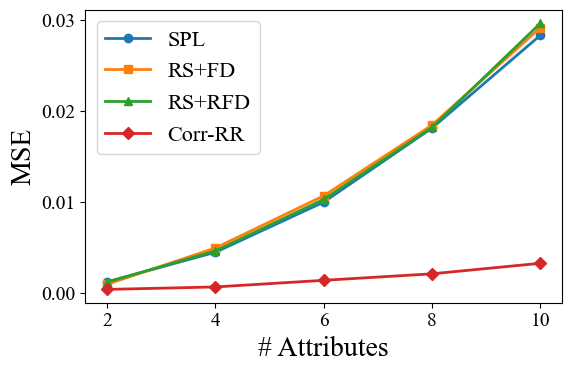

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = [0, 1]                   # binary values
attribute_counts = [2, 4, 6, 8, 10]
epsilon = 0.6                     # fixed privacy budget
n = 10000
m = 0.1                           # fraction for SPL
R = 100                           # number of runs

# Pre-allocate storage: rows=runs, cols=|attribute_counts|
all_spl    = np.zeros((R, len(attribute_counts)))
all_rsfd   = np.zeros((R, len(attribute_counts)))
all_rsrfd  = np.zeros((R, len(attribute_counts)))
all_corrrr = np.zeros((R, len(attribute_counts)))

for run in range(R):
    for idx, d in enumerate(attribute_counts):
        # 1) build columns names and correlations
        columns = [f'X{i+1}' for i in range(d)]
        # fully connect every pair at corr=0.98
        correlations = [
            (columns[i], columns[j], 0.98)
            for i in range(d) for j in range(i+1, d)
        ]

        # 2) generate data & true frequencies
        df = correlated_data_generator(domain, n, correlations=correlations)
        true_freqs = get_true_frequencies(df, columns)
        domains = {col: sorted(df[col].unique()) for col in columns}

        # --- compute MSE for each mechanism at ε=0.1 ---
        # 2a) SPL
        pert_spl = random_split_perturb(df, epsilon)
        est_spl  = random_split_estimate(pert_spl, df, epsilon)
        mse_spl = np.mean([
            np.mean([
                (est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2b) RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, epsilon)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, epsilon)
        mse_rsfd = np.mean([
            np.mean([
                (est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2c) RS + RFD
        priors     = true_freqs  # empirical priors
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, epsilon)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, epsilon)
        mse_rsrfd = np.mean([
            np.mean([
                (est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2d) Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, epsilon, frac=m)
        n_A = int(m * len(df))
        n_B = len(df_B)
        # build p_y for every pair
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b],
                                epsilon, n_A, domain)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, epsilon,
                                             phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, epsilon)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr = np.mean([
            np.mean([
                (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 3) record
        all_spl[run,    idx] = mse_spl
        all_rsfd[run,   idx] = mse_rsfd
        all_rsrfd[run,  idx] = mse_rsrfd
        all_corrrr[run, idx] = mse_corrrr

# --- average over runs ---
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)




# --- plot: #attributes vs MSE curves ---
plt.figure(figsize=(6,4))
plt.plot(attribute_counts, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(attribute_counts, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(attribute_counts, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(attribute_counts, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')

plt.xlabel('# Attributes', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(attribute_counts, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_100k_10_98_eps_0_6.svg", format="svg")

plt.show()


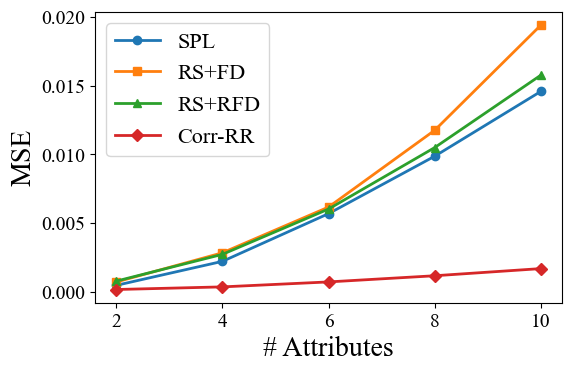

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = [0, 1]                   # binary values
attribute_counts = [2, 4, 6, 8, 10]
epsilon = 0.8                     # fixed privacy budget
n = 10000
m = 0.1                           # fraction for SPL
R = 100                           # number of runs

# Pre-allocate storage: rows=runs, cols=|attribute_counts|
all_spl    = np.zeros((R, len(attribute_counts)))
all_rsfd   = np.zeros((R, len(attribute_counts)))
all_rsrfd  = np.zeros((R, len(attribute_counts)))
all_corrrr = np.zeros((R, len(attribute_counts)))

for run in range(R):
    for idx, d in enumerate(attribute_counts):
        # 1) build columns names and correlations
        columns = [f'X{i+1}' for i in range(d)]
        # fully connect every pair at corr=0.98
        correlations = [
            (columns[i], columns[j], 0.98)
            for i in range(d) for j in range(i+1, d)
        ]

        # 2) generate data & true frequencies
        df = correlated_data_generator(domain, n, correlations=correlations)
        true_freqs = get_true_frequencies(df, columns)
        domains = {col: sorted(df[col].unique()) for col in columns}

        # --- compute MSE for each mechanism at ε=0.1 ---
        # 2a) SPL
        pert_spl = random_split_perturb(df, epsilon)
        est_spl  = random_split_estimate(pert_spl, df, epsilon)
        mse_spl = np.mean([
            np.mean([
                (est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2b) RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, epsilon)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, epsilon)
        mse_rsfd = np.mean([
            np.mean([
                (est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2c) RS + RFD
        priors     = true_freqs  # empirical priors
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, epsilon)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, epsilon)
        mse_rsrfd = np.mean([
            np.mean([
                (est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2d) Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, epsilon, frac=m)
        n_A = int(m * len(df))
        n_B = len(df_B)
        # build p_y for every pair
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b],
                                epsilon, n_A, domain)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, epsilon,
                                             phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, epsilon)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr = np.mean([
            np.mean([
                (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 3) record
        all_spl[run,    idx] = mse_spl
        all_rsfd[run,   idx] = mse_rsfd
        all_rsrfd[run,  idx] = mse_rsrfd
        all_corrrr[run, idx] = mse_corrrr

# --- average over runs ---
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)




# --- plot: #attributes vs MSE curves ---
plt.figure(figsize=(6,4))
plt.plot(attribute_counts, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(attribute_counts, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(attribute_counts, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(attribute_counts, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')

plt.xlabel('# Attributes', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(attribute_counts, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_100k_10_98_eps_0_8.svg", format="svg")

plt.show()


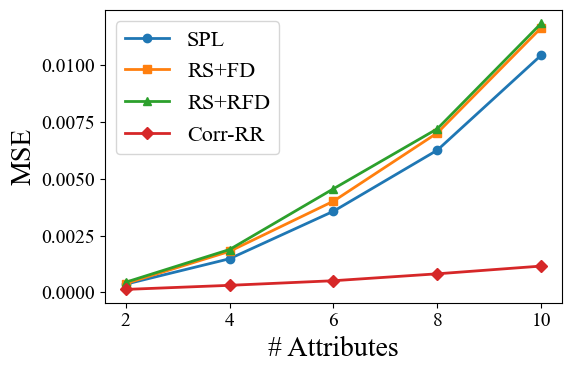

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = [0, 1]                   # binary values
attribute_counts = [2, 4, 6, 8, 10]
epsilon = 1                     # fixed privacy budget
n = 10000
m = 0.1                           # fraction for SPL
R = 100                           # number of runs

# Pre-allocate storage: rows=runs, cols=|attribute_counts|
all_spl    = np.zeros((R, len(attribute_counts)))
all_rsfd   = np.zeros((R, len(attribute_counts)))
all_rsrfd  = np.zeros((R, len(attribute_counts)))
all_corrrr = np.zeros((R, len(attribute_counts)))

for run in range(R):
    for idx, d in enumerate(attribute_counts):
        # 1) build columns names and correlations
        columns = [f'X{i+1}' for i in range(d)]
        # fully connect every pair at corr=0.98
        correlations = [
            (columns[i], columns[j], 0.98)
            for i in range(d) for j in range(i+1, d)
        ]

        # 2) generate data & true frequencies
        df = correlated_data_generator(domain, n, correlations=correlations)
        true_freqs = get_true_frequencies(df, columns)
        domains = {col: sorted(df[col].unique()) for col in columns}

        # --- compute MSE for each mechanism at ε=0.1 ---
        # 2a) SPL
        pert_spl = random_split_perturb(df, epsilon)
        est_spl  = random_split_estimate(pert_spl, df, epsilon)
        mse_spl = np.mean([
            np.mean([
                (est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2b) RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, epsilon)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, epsilon)
        mse_rsfd = np.mean([
            np.mean([
                (est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2c) RS + RFD
        priors     = true_freqs  # empirical priors
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, epsilon)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, epsilon)
        mse_rsrfd = np.mean([
            np.mean([
                (est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2d) Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, epsilon, frac=m)
        n_A = int(m * len(df))
        n_B = len(df_B)
        # build p_y for every pair
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b],
                                epsilon, n_A, domain)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, epsilon,
                                             phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, epsilon)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr = np.mean([
            np.mean([
                (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 3) record
        all_spl[run,    idx] = mse_spl
        all_rsfd[run,   idx] = mse_rsfd
        all_rsrfd[run,  idx] = mse_rsrfd
        all_corrrr[run, idx] = mse_corrrr

# --- average over runs ---
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)




# --- plot: #attributes vs MSE curves ---
plt.figure(figsize=(6,4))
plt.plot(attribute_counts, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(attribute_counts, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(attribute_counts, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(attribute_counts, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')

plt.xlabel('# Attributes', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(attribute_counts, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_100k_10_98_eps_1.svg", format="svg")

plt.show()


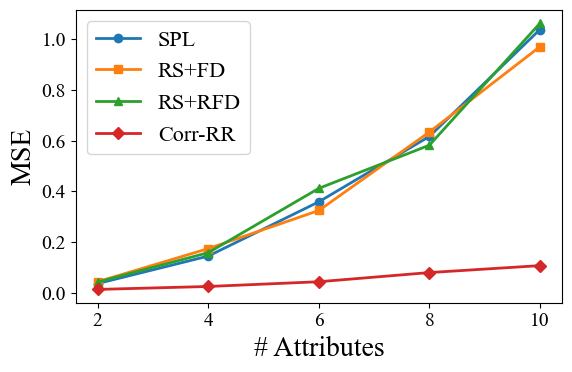

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = [0, 1]                   # binary values
attribute_counts = [2, 4, 6, 8, 10]
epsilon = 0.1                     # fixed privacy budget
n = 10000
m = 0.1                           # fraction for SPL
R = 100                           # number of runs

# Pre-allocate storage: rows=runs, cols=|attribute_counts|
all_spl    = np.zeros((R, len(attribute_counts)))
all_rsfd   = np.zeros((R, len(attribute_counts)))
all_rsrfd  = np.zeros((R, len(attribute_counts)))
all_corrrr = np.zeros((R, len(attribute_counts)))

for run in range(R):
    for idx, d in enumerate(attribute_counts):
        # 1) build columns names and correlations
        columns = [f'X{i+1}' for i in range(d)]
        # fully connect every pair at corr=0.98
        correlations = [
            (columns[i], columns[j], 0.98)
            for i in range(d) for j in range(i+1, d)
        ]

        # 2) generate data & true frequencies
        df = correlated_data_generator(domain, n, correlations=correlations)
        true_freqs = get_true_frequencies(df, columns)
        domains = {col: sorted(df[col].unique()) for col in columns}

        # --- compute MSE for each mechanism at ε=0.1 ---
        # 2a) SPL
        pert_spl = random_split_perturb(df, epsilon)
        est_spl  = random_split_estimate(pert_spl, df, epsilon)
        mse_spl = np.mean([
            np.mean([
                (est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2b) RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, epsilon)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, epsilon)
        mse_rsfd = np.mean([
            np.mean([
                (est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2c) RS + RFD
        priors     = true_freqs  # empirical priors
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, epsilon)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, epsilon)
        mse_rsrfd = np.mean([
            np.mean([
                (est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2d) Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, epsilon, frac=m)
        n_A = int(m * len(df))
        n_B = len(df_B)
        # build p_y for every pair
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b],
                                epsilon, n_A, domain)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, epsilon,
                                             phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, epsilon)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr = np.mean([
            np.mean([
                (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 3) record
        all_spl[run,    idx] = mse_spl
        all_rsfd[run,   idx] = mse_rsfd
        all_rsrfd[run,  idx] = mse_rsrfd
        all_corrrr[run, idx] = mse_corrrr

# --- average over runs ---
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)




# --- plot: #attributes vs MSE curves ---
plt.figure(figsize=(6,4))
plt.plot(attribute_counts, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(attribute_counts, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(attribute_counts, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(attribute_counts, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')

plt.xlabel('# Attributes', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(attribute_counts, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_100k_10_98_eps_0_1.svg", format="svg")

plt.show()


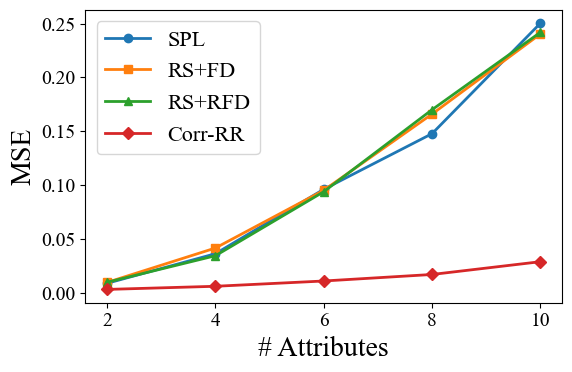

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = [0, 1]                   # binary values
attribute_counts = [2, 4, 6, 8, 10]
epsilon = 0.2                     # fixed privacy budget
n = 10000
m = 0.1                           # fraction for SPL
R = 100                           # number of runs

# Pre-allocate storage: rows=runs, cols=|attribute_counts|
all_spl    = np.zeros((R, len(attribute_counts)))
all_rsfd   = np.zeros((R, len(attribute_counts)))
all_rsrfd  = np.zeros((R, len(attribute_counts)))
all_corrrr = np.zeros((R, len(attribute_counts)))

for run in range(R):
    for idx, d in enumerate(attribute_counts):
        # 1) build columns names and correlations
        columns = [f'X{i+1}' for i in range(d)]
        # fully connect every pair at corr=0.98
        correlations = [
            (columns[i], columns[j], 0.98)
            for i in range(d) for j in range(i+1, d)
        ]

        # 2) generate data & true frequencies
        df = correlated_data_generator(domain, n, correlations=correlations)
        true_freqs = get_true_frequencies(df, columns)
        domains = {col: sorted(df[col].unique()) for col in columns}

        # --- compute MSE for each mechanism at ε=0.1 ---
        # 2a) SPL
        pert_spl = random_split_perturb(df, epsilon)
        est_spl  = random_split_estimate(pert_spl, df, epsilon)
        mse_spl = np.mean([
            np.mean([
                (est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2b) RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, epsilon)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, epsilon)
        mse_rsfd = np.mean([
            np.mean([
                (est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2c) RS + RFD
        priors     = true_freqs  # empirical priors
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, epsilon)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, epsilon)
        mse_rsrfd = np.mean([
            np.mean([
                (est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 2d) Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, epsilon, frac=m)
        n_A = int(m * len(df))
        n_B = len(df_B)
        # build p_y for every pair
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b],
                                epsilon, n_A, domain)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, epsilon,
                                             phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, epsilon)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr = np.mean([
            np.mean([
                (combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                for v in domain
            ])
            for col in columns
        ])

        # 3) record
        all_spl[run,    idx] = mse_spl
        all_rsfd[run,   idx] = mse_rsfd
        all_rsrfd[run,  idx] = mse_rsrfd
        all_corrrr[run, idx] = mse_corrrr

# --- average over runs ---
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)




# --- plot: #attributes vs MSE curves ---
plt.figure(figsize=(6,4))
plt.plot(attribute_counts, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(attribute_counts, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(attribute_counts, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(attribute_counts, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')

plt.xlabel('# Attributes', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(attribute_counts, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_100k_10_98_eps_0_2.svg", format="svg")

plt.show()


In [14]:
import matplotlib as mpl

# --- set global font to Times New Roman ---
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,            # switch to True if you have a TeX installation
    'font.size': 16,                 # fallback for general text
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.titlesize': 20,
})